In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

from utils import single_img_features, visualize, extract_features, slide_window, search_windows, draw_boxes, get_hog_features, bin_spatial, color_hist, cvtColor

## Load data

In [2]:
cars = []
notcars = []

basedir = 'test_images/vehicles'
for d in os.listdir(basedir):
    cars.extend(glob.glob(basedir + '/' + d + '/*.png'))

basedir = 'test_images/non-vehicles'
for d in os.listdir(basedir):
    notcars.extend(glob.glob(basedir + '/' + d + '/*.png'))

print('%d car image found' % len(cars))
print('%d noncar image found' % len(notcars))

8792 car image found
8968 noncar image found


### Place for local testing parameters

In [3]:
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

### Extract features from single image and show it up

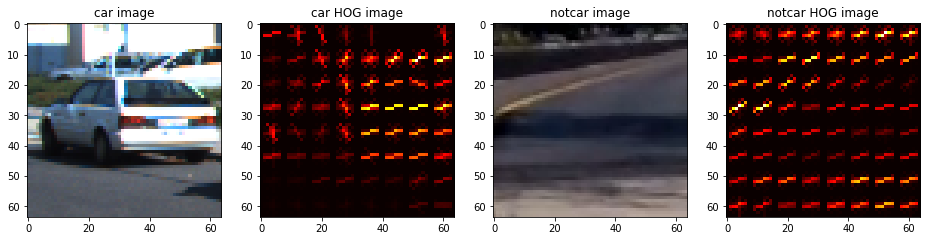

In [4]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_image = cv2.imread(cars[car_ind])
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
notcar_image = cv2.imread(notcars[car_ind])
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB)

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']

fig = plt.figure(figsize=(16, 12))
visualize(fig, 1, 4, images, titles)

### Extract features for training

In [5]:
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

In [6]:
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

### Normalization and split to training/testing sets

In [7]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

### Traing the SVM model

In [8]:
clf = LinearSVC()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.99296171171171166

### Sliding window parameters

In [9]:
x_start_stop = [None, None]
y_start_stop = [400, 656]
xy_window = (64, 64)
xy_overlap = (0.5, 0.5)

### Testing the result with some actual images

I captured these images from the project video.

1.2025339603424072 seconds to process one image searching 273 windows 5 hot windows
1.2394740581512451 seconds to process one image searching 273 windows 4 hot windows
1.225672960281372 seconds to process one image searching 273 windows 1 hot windows
1.2249879837036133 seconds to process one image searching 273 windows 0 hot windows
1.201521873474121 seconds to process one image searching 273 windows 0 hot windows
1.2899079322814941 seconds to process one image searching 273 windows 3 hot windows


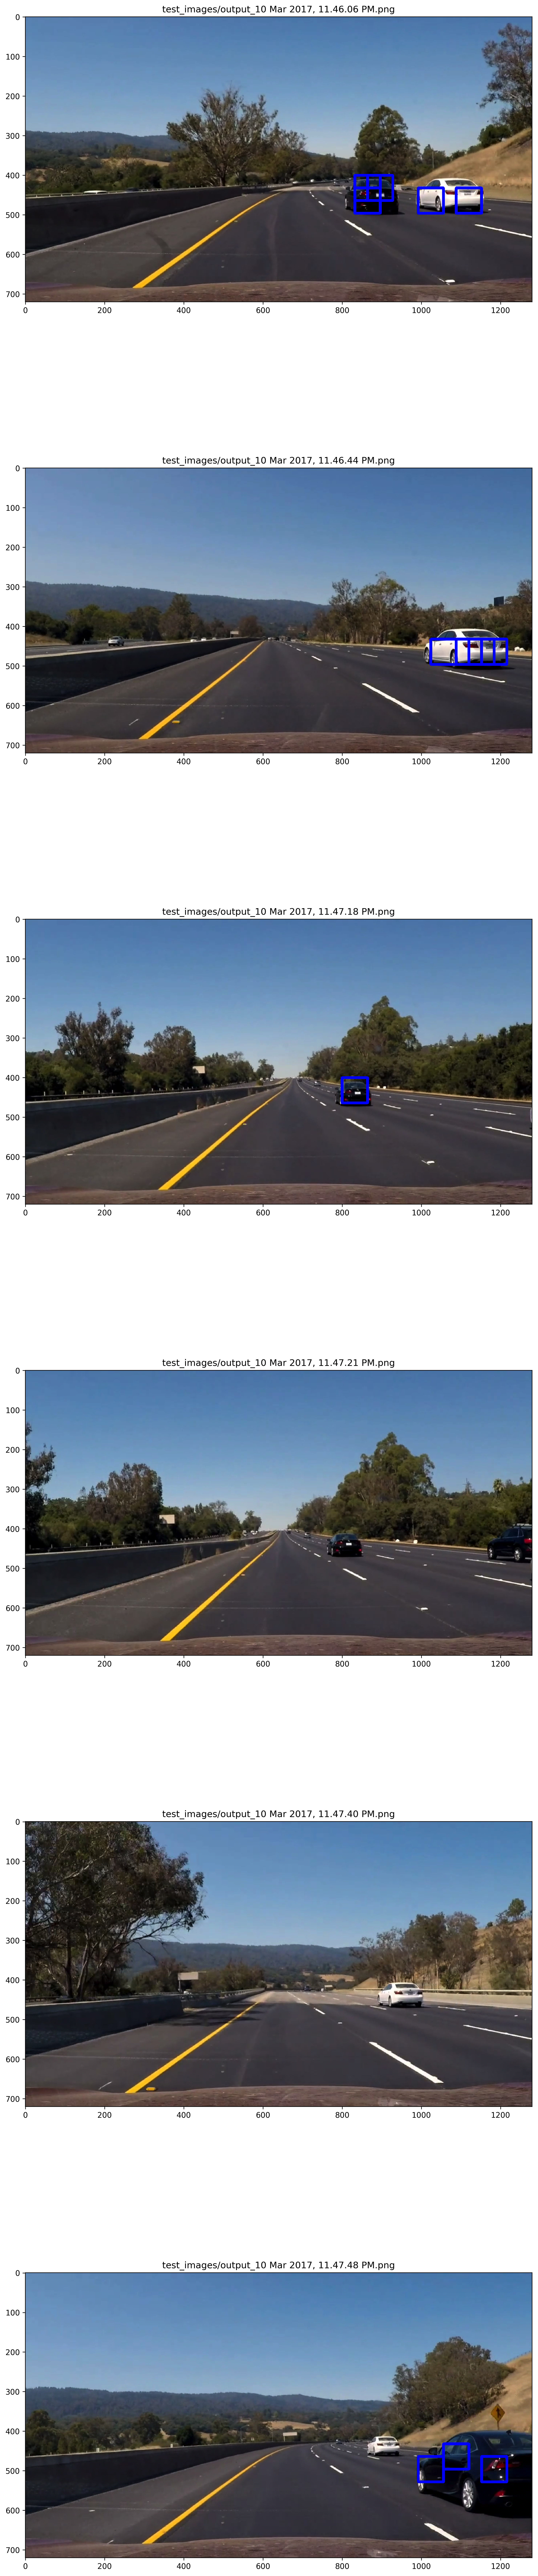

In [10]:
test_images = glob.glob('test_images/out*.png')
images = []
titles = []
for i in test_images:
    t1 = time.time()
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    windows = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                    xy_window=xy_window, xy_overlap=xy_overlap)
    
    hot_windows = search_windows(img, windows, clf, X_scaler, color_space=color_space,
                    spatial_size=spatial_size, hist_bins=hist_bins,
                    orient=orient,
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                    hog_channel=hog_channel, spatial_feat=True,
                    hist_feat=True, hog_feat=True)
    t2 = time.time()
    print(t2-t1, 'seconds to process one image searching', len(windows), 'windows', len(hot_windows), 'hot windows')
    window_img = draw_boxes(img, hot_windows)
    images.append(window_img)
    titles.append(i)

fig = plt.figure(figsize=(12, 64), dpi=300)
visualize(fig, 6, 1, images, titles)

### Major parameters

In [11]:
out_images = [] # annotated images
out_titles = []
out_heatmaps = []
out_boxes = []
scale = 1
ystart = 400
ystop = 656
image_w = 1280
image_h = 720

scaled_w = image_w // scale
scaled_h = (ystop-ystart) // scale

nxblocks = (scaled_w // pix_per_cell) - 1
nyblocks = (scaled_h // pix_per_cell) - 1
window = 64
nblocks_per_window = (window // pix_per_cell) - 1
cells_per_step = 2
nxsteps = int((nxblocks - nblocks_per_window) // cells_per_step)
nysteps = int((nyblocks - nblocks_per_window) // cells_per_step)

In [22]:
def find_cars(img, scale):
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:, :, 0])
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = cvtColor(img_tosearch, color_space)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (int(imshape[1]//scale), int(imshape[0]//scale)))

    if hog_channel != 'ALL':
        ch = ctrans_tosearch[:, :, hog_channel]
        hog = get_hog_features(ch, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        ch1 = ctrans_tosearch[:, :, 0]
        ch2 = ctrans_tosearch[:, :, 1]
        ch3 = ctrans_tosearch[:, :, 2]
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            if hog_channel != 'ALL':
                hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            else:
                hog_features = np.hstack((hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel(),
                                         hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel(),
                                         hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))

            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            all_features = np.hstack((spatial_features, hist_features, hog_features))

            test_features = X_scaler.transform(all_features.reshape(1, -1))

            test_prediction = clf.predict(test_features)

            if test_prediction:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale) + ystart
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw), (xbox_left+win_draw, ytop_draw+win_draw), color=(0, 0, 255), thickness = 6)
                heatmap[ytop_draw:ytop_draw+win_draw, xbox_left-20:xbox_left+win_draw+10] += 1

    return draw_img, heatmap

In [23]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_numbers in range(1, labels[1]+1):
        nonzero = (labels[0] == car_numbers).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    return img

12


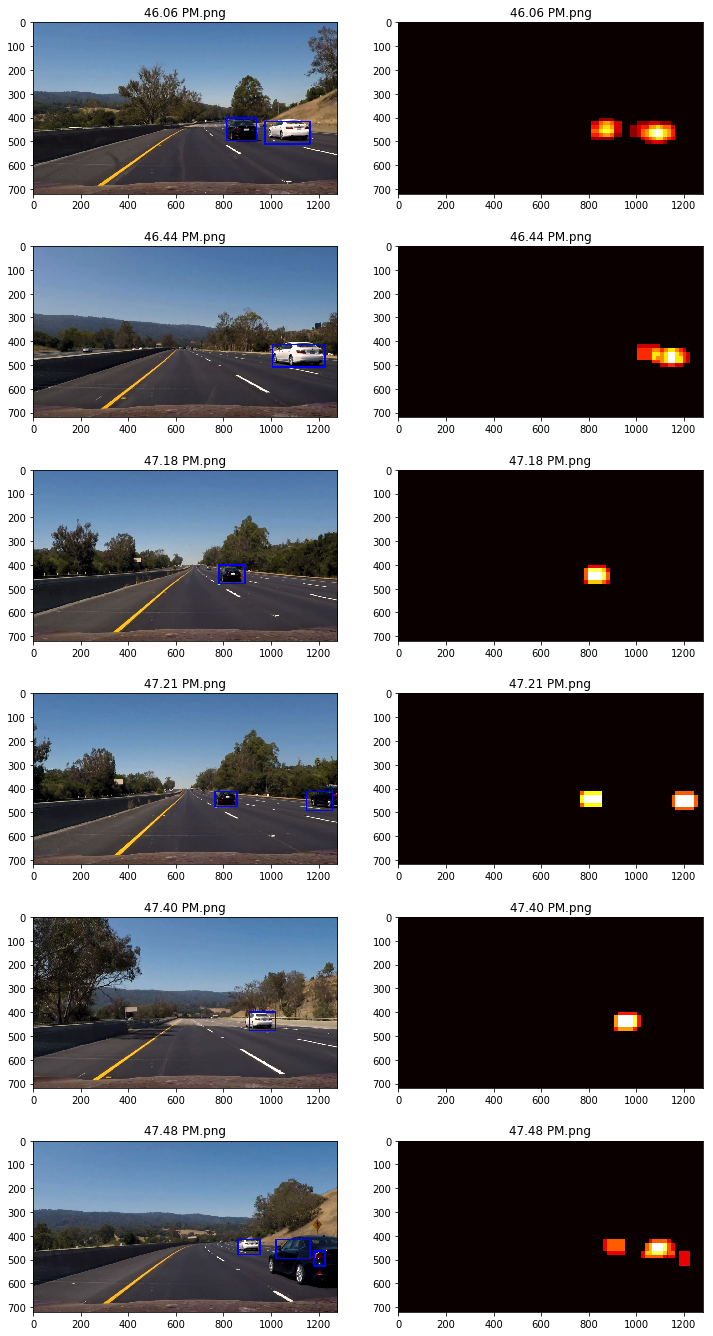

In [24]:
out_images = []
out_maps = []
for img_file in test_images:
    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    out_img, heat_map = find_cars(img, 1)
    heat_map = apply_threshold(heat_map, 1)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    out_titles.append(img_file[-12:])
    out_titles.append(img_file[-12:])

    
print(len(out_images))
fig = plt.figure(figsize=(12, 24))
visualize(fig, 6, 2, out_images, out_titles)

In [25]:
from imageio.plugins.ffmpeg import download
download()

### Process video

In [ ]:
from moviepy.editor import VideoFileClip

def process_image(img):
    out_img, heat_map = find_cars(img, 1)
    heat_map = apply_threshold(heat_map, 2)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img
output = 'output_images/output.mp4'
clip1 = VideoFileClip('project_video.mp4').subclip(20, 25)
clip = clip1.fl_image(process_image)
clip.write_videofile(output, audio=False)

### Process video with several previous frames

In [27]:
def fn(x, y):
    if isinstance(y, int):
        return x
    return x + y

total_cases = 10 # 5 / 25 frames = 0.2s
heat_map_queue = [0 for i in range(total_cases)]

current_case = 0

In [28]:
from functools import reduce

def process_image_v2(img):
    global current_case
    out_img, heat_map = find_cars(img, 1)
    heat_map_queue[current_case % total_cases] = heat_map
    current_case += 1
    overall_heatmap = reduce(fn, heat_map_queue)

    overall_heatmap = apply_threshold(overall_heatmap, 6)
    labels = label(overall_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img
output = 'output_images/output.mp4'
clip1 = VideoFileClip('project_video.mp4') #.subclip(34, 38)
clip = clip1.fl_image(process_image_v2)
clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/output.mp4
[MoviePy] Writing video output_images/output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<19:47,  1.06it/s]

  0%|          | 2/1261 [00:01<19:37,  1.07it/s]

  0%|          | 3/1261 [00:02<19:44,  1.06it/s]

  0%|          | 4/1261 [00:03<19:36,  1.07it/s]

  0%|          | 5/1261 [00:04<19:30,  1.07it/s]

  0%|          | 6/1261 [00:05<19:05,  1.10it/s]

  1%|          | 7/1261 [00:06<18:53,  1.11it/s]

  1%|          | 8/1261 [00:07<18:49,  1.11it/s]

  1%|          | 9/1261 [00:08<18:51,  1.11it/s]

  1%|          | 10/1261 [00:09<18:45,  1.11it/s]

  1%|          | 11/1261 [00:09<18:36,  1.12it/s]

  1%|          | 12/1261 [00:10<18:32,  1.12it/s]

  1%|          | 13/1261 [00:11<18:37,  1.12it/s]

  1%|          | 14/1261 [00:12<18:36,  1.12it/s]

  1%|          | 15/1261 [00:13<18:26,  1.13it/s]

  1%|▏         | 16/1261 [00:14<18:14,  1.14it/s]

  1%|▏         | 17/1261 [00:15<18:13,  1.14it/s]

  1%|▏         | 18/1261 [00:16<18:12,  1.14it/s]

  2%|▏         | 19/1261 [00:17<18:12,  1.14it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/output.mp4 

